In [ ]:
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pdb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from array import array
from IPython.display import clear_output
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
!pip install tsaug
import tsaug
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse,AddNoise,Convolve
import keras.backend as K
import math

#we decide which file to include in the validation set
valid_files = ['./Short-FBT-1.xlsx']#,'Short-FBT-2.xlsx']#,'Short-FBT-5.xlsx']


In [ ]:
def normalize(X, Y):
    '''it scales the features and the target between -1 and 1
    parameters: 
        - X: the features data
        - Y: the target data
    returns: 
        - X : the normalized features data
        - Y : the normalized target data

    '''
    scaler = MinMaxScaler(feature_range=(0, 1.0))
    norm_X = scaler.fit_transform(X)
    norm_Y = scaler.fit_transform(Y)
    return norm_X, norm_Y, scaler

In [ ]:
my_augmenter = (
     TimeWarp() * 5 
     + Reverse() @ 0.5
    + AddNoise(prob =0.5)
    + Convolve(prob=0.5)
    + tsaug.Drift(max_drift=0.7, n_drift_points=5)
    + tsaug.Pool(size=2)
)


def augment_data(x_data_train,y_data_train):
  '''it takes the training set and generate an augmented dataset that will be added to the existing one
    parameters: 
        - x_data_train: the original traing set 
        - y_data_train: the original training set' labels
    returns: 
        - x_data_train: the new training set with the augmented set appended
        - y_data_train :the new training set' labels with the augmented set appended
  '''
  #pdb.set_trace() #debug

  n_features = x_data_train.shape[1]
  #column wise stacking X and Y before doing augmentation
  X = np.hstack( (x_data_train,y_data_train))
  X = X.reshape(1,-1,n_features + 1)
  X_aug, _ = my_augmenter.augment(X, X)
  #stacking the augmented dataset to the orginal one
  for i in range(X_aug.shape[0]):
    x_data_train = np.vstack( (x_data_train,X_aug[i,:,:n_features]))
    y_data_train = np.vstack( (y_data_train,X_aug[i,:,n_features].reshape(-1,1)))
  return x_data_train,y_data_train

In [ ]:
def read_data(filename,use_ma = False):
    '''
    it reads the uploaded data file and preprocess it : 
        params
        -filename: the dataset's filename 
 
        returns:
            -data: preprocessed data
            - friction: the friction data
            - options: the data's labels for each dataset's column
            - found_friction: whether the friction was detected 
    '''
    df = pd.read_excel(filename)
 
    # Drop NaN columns
    df.dropna(axis='columns', how='all', inplace=True)
 
    # Find friction and time column
    headers = list(df)
    used_headers = list()
 
    found_friction = False
    for i in headers:
        if 'fri' in i.lower():
            f_index = headers.index(i)
            #we use the moving average of our target as the new target
            if use_ma:
              moving_avg = df[i].rolling(window=100).mean().fillna(method='bfill')
              friction_df = moving_avg   #mean friction  

            friction_df = df[[i]].copy()    #real friction 
            df.drop(i, axis=1, inplace=True)
            found_friction = True
 
        elif 'time' in i.lower():
            t_index = headers.index(i)
            # time = pd.Series(np.arange(len(df[i])))
            #df.insert(len(df.columns),'time', time, False)  
            df.drop(i, axis=1, inplace=True)
        elif 'cof' in i.lower():
            t_index = headers.index(i)
            df.drop(i, axis=1, inplace=True)
        elif 'speed' in i.lower():
             used_headers.append(i.lower().split()[0])
        elif 'load' in i.lower() or 'temp' in i.lower():
            #compute
            moving_avg = df[i].rolling(window=100).mean().fillna(method='bfill').values.tolist()
            #we compute the rolling mean as a new feature
            mean = df[i].rolling(window=60).mean().fillna(method='bfill').values.tolist()   
            #we compute the rolling std was a new feature
            std = df[i].rolling(window=100).std().fillna(method='bfill').values.tolist()
            #we compute the expanding mean as a new feature
            expanding_window_mean = df[i].expanding(10).mean().fillna(method='bfill').values.tolist()
            #updated df
            if use_ma:
              #add moving average as latent variable
              df.insert(len(df.columns),i.lower().split()[0]+'_avg_mean', moving_avg, False) 
              df.drop(i, axis=1, inplace=True
                      
            df.insert(len(df.columns),i.lower().split()[0]+'_mean', mean, False) 
            df.insert(len(df.columns),i.lower().split()[0]+'_std', std, False)
            df.insert(len(df.columns),i.lower().split()[0]+'_exp_mean', std, False) 
            )
            used_headers.append(i.lower().split()[0])
            used_headers.append(i.lower().split()[0] + '_avg_mean')
            used_headers.append(i.lower().split()[0] + '_mean')
            used_headers.append(i.lower().split()[0] + 'std')
            used_headers.append(i.lower().split()[0] + 'exp_mean')
        else:
         df.drop(i, axis=1, inplace=True)
 
    # Split into X (features) and Y (labels)
    data = df.to_numpy()
    data = data.astype('float32')
 
    if (found_friction):
        friction = friction_df.to_numpy()
        friction = friction.astype('float32')
    else:
        friction = None
 
    return (data, friction, used_headers, found_friction)

In [ ]:
def read_excel_files(augment=False): 
  '''
    it reads all the uploaded datasets and split them into train/validation : 
        params: 
          - augment: whether to augment dataset
        returns:
            - x_data_train: numpy containing train data
            - x_data_valid: numpy containing valid data
            - y_data_valid: numpy containing label for valid data
            - y_data_train: numpy containing label for train data 
    '''
  files = glob.glob('./*.xlsx')

  #we initialize the empty numpy arrays for the dataset 
  x_data_train = x_data_valid =  np.empty(7).astype('float32')
  y_data_train = y_data_valid  =np.empty(1).astype('float32')
  #last dataset used for validation
  for f in files[:]:
    if f not in valid_files:
      data, friction_data, used_headers, found_friction = read_data(f)
      for i,d in enumerate(data[:]): 
        #include the processed excl file's features in the dataset
        if (found_friction):
          x_data_train = np.vstack( (x_data_train,d))
 
      for friction in friction_data[:]:
        #include the processed excl file's target in the dataset
        if (found_friction):
          y_data_train = np.vstack( (y_data_train,friction))
 
  for f in valid_files:
    data, friction_data, used_headers, found_friction = read_data(f)
    for i,d in enumerate(data[:]): 
      if (found_friction):
        #assert len(d) == 3
        x_data_valid = np.vstack( (x_data_valid,d))
 
    for friction in friction_data[:]:
      if (found_friction):
        y_data_valid = np.vstack( (y_data_valid,friction))
 
  #augment data
  x_data_train = x_data_train[1:]
  x_data_valid = x_data_valid[1:]
  y_data_valid = y_data_valid[1:]
  y_data_train = y_data_train[1:]
  if augment == True: 
    x_data_train,y_data_train = augment_data(x_data_train,y_data_train)

  #check there are no gaps
  assert len(x_data_train) == len(y_data_train)
  assert len(x_data_valid) == len(y_data_valid)
  return x_data_train,y_data_train,x_data_valid,y_data_valid

In [ ]:
from keras.callbacks import LearningRateScheduler
'''
callback for plotting the losses on each epoch

'''
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();


class PredictionCallback(tf.keras.callbacks.Callback):    
  def __init__(self, val_data,train_data):
        super().__init__()
        self.validation_data = val_data
        self.train_data = train_data

  def on_epoch_end(self, epoch, logs={}):
    #pdb.set_trace()
    y_pred = self.model.predict(self.validation_data[0])
    #y_pred = y_pred.reshape(y_pred.shape[0]*y_pred.shape[1],1)
    #y_pred = y_pred[:,-1,:]
    vad = self.validation_data[1]
    #vad = self.validation_data[1].reshape(self.validation_data[1].shape[0]*self.validation_data[1].shape[1],1)
    #y_pred = y_pred.reshape(y_pred.shape[0],1)
    #print('prediction: {} at epoch: {}'.format(y_pred, epoch))
    #print('true: {} at epoch: {}'.format(self.validation_data[1], epoch))
    plt.figure()
    plt.plot(y_pred, label="preds")
    plt.plot(vad, label="true data")
    plt.legend()
    plt.show();
    y_pred2 = self.model.predict(self.train_data[0])
    #y_pred2 = y_pred2[:,-1,:]
    #y_pred2 = y_pred2.reshape(y_pred2.shape[0],1)
    plt.figure()
    plt.plot(y_pred2, label="preds")
    plt.plot(self.train_data[1], label="true data")
    plt.legend()
    plt.show();

# learning rate schedule
def step_decay(epoch):
	initial_lrate = 3e-3
	drop = 0.5
	epochs_drop = 48.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lrate = LearningRateScheduler(step_decay)
plot_losses = PlotLosses()
checkpoint_filepath = '/tmp/checkpoint'
  
my_callbacks = [
    plot_losses,
    tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_root_mean_squared_error',
    mode='max',
    save_best_only=True),
    lrate
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]



In [1]:
class Wave(layers.Layer):
    """Simple stack of Linear layers."""

    def __init__(self,num_filters,n_timesteps,n_features,dropout_perc = 0.2):
        super(Wave, self).__init__()
        self.dropout_perc = dropout_perc
        self.inputLayer = tf.keras.layers.InputLayer(input_shape=[n_timesteps, n_features])
        self.conv0 = tf.keras.layers.Conv1D(filters=num_filters,kernel_size=1)
        self.convEq = tf.keras.layers.Conv1D(filters=num_filters*256,kernel_size=1)
        self.conv1 = tf.keras.layers.Conv1D(filters=num_filters,kernel_size=2,strides=1,dilation_rate=1,padding="causal",activation='relu')
        self.conv2 = tf.keras.layers.Conv1D(filters=num_filters,kernel_size=2,strides=1,dilation_rate=4,padding="causal",activation='relu')
        self.conv3 = tf.keras.layers.Conv1D(filters=num_filters,kernel_size=2,strides=1,dilation_rate=16,padding="causal",activation='relu')
        self.conv4 = tf.keras.layers.Conv1D(filters=num_filters,kernel_size=2,strides=1,dilation_rate=64,padding="causal",activation='relu')
        self.convFinal = tf.keras.layers.Conv1D(filters=1,kernel_size=1,activation='relu')
        
        self.linearOutput1 = tf.keras.layers.Dense(n_features)
        #we get one value back
        self.finalLinearOutput = tf.keras.layers.Dense(1)
    

    def resBlock(self,inputs):
      x1 = self.conv1(inputs)
      x1 = tf.keras.layers.BatchNormalization()(x1)
      x1 = tf.keras.layers.Dropout(self.dropout_perc)(x1)

      x2 = self.conv2(x1)
      x2 = tf.keras.layers.BatchNormalization()(x2)
      x2 = tf.keras.layers.Dropout(self.dropout_perc)(x2)

      x2_r = tf.keras.layers.Add()([x2,inputs])


      x3 = self.conv3(x2_r)
      x3 = tf.keras.layers.BatchNormalization()(x3)
      x3 = tf.keras.layers.Dropout(self.dropout_perc)(x3)
      
      x4 = self.conv4(x3)
      x4 = tf.keras.layers.BatchNormalization()(x4)
      x4 = tf.keras.layers.Dropout(self.dropout_perc)(x4)
      
      x4_r = tf.keras.layers.Add()([x2_r,x4])

      return x4_r
      
    def call(self, inputs):
        inputs = self.inputLayer(inputs)
        inputs = self.conv0(inputs)
        
        r1 = self.resBlock(inputs)
        #r2 = self.resBlock(r1)
        #r3 = self.resBlock(r2)

        #v = self.linearOutput1(r1)
        v = tf.keras.layers.Flatten()(r1)
        return self.finalLinearOutput(v)

loss_fn =tf.keras.losses.MeanSquaredError()
metric = val_acc_metric = tf.keras.metrics.RootMeanSquaredError()

#lr schedule for a better converrgence
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule,decay=1e-2,name='adam')

NameError: ignored

In [ ]:
def fit(model,num_epochs,train_dataset,val_dataset):
  for epoch in range(num_epochs):
    print("\nStart of epoch %d" % (epoch,))

    
    # Iterate over the batches of the dataset.
    predictions = np.empty([1,1])
    targets = np.empty([1,1])
    loss_value = loss_batch = 0
    val_loss = val_loss_batch = 0
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

      # Open a GradientTape to record the operations run
      # during the forward pass, which enables auto-differentiation.
      
      with tf.GradientTape() as tape:

        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        
        prediction = model(x_batch_train, training=True)  # Logits for this minibatch
        # Compute the loss value for this minibatch.
        loss_batch = loss_fn(y_batch_train, prediction)
        loss_value += loss_batch
        predictions =np.vstack((predictions,prediction))
        targets = np.vstack((targets,y_batch_train))

      # Use the gradient tape to automatically retrieve
      # the gradients of the trainable variables with respect to the loss.
      grads = tape.gradient(loss_batch, model.trainable_weights)

      # Run one step of gradient descent by updating
      # the value of the variables to minimize the loss.
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

    print("Training loss (for one batch) at step %d: %.4f"% (step, float(loss_value/(step+1))))   
    # Update training metric.
    train_acc_metric.update_state(y_batch_train, logits)
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    
    # plot results
    if epoch % 10 == 0:
        plt.figure()
        plt.plot(prediction[1:] , label="preds")
        plt.plot(targets[1:], label="true data")
        plt.legend()
        plt.show();

    #Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    predictions = np.empty([1,1])
    targets = np.empty([1,1])
    # Run a validation loop at the end of each epoch.
    for step,(x_batch_val, y_batch_val) in enumerate(val_dataset):
        val_prediction = model(x_batch_val, training=False)
        val_loss += loss_fn(y_batch_val, val_logits)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_prediction)
        predictions =np.vstack((predictions,val_logits))
        targets = np.vstack((targets,y_batch_val))

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Validation loss: %.4f" % (float(val_loss/(step)),))

    #plot results
    if epoch % 10 == 0:
      plt.figure()
      plt.plot(b1[1:], label="preds")
      plt.plot(b2[1:], label="true data")
      plt.legend()
      plt.show();
    


# convert history into inputs and outputs
def to_supervised_sequence(X, Y, n_input, n_out=1):
  X_list, y_list = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  #pdb.set_trace()
  for _ in range(len(X)):
    # define the end of the input sequence
    in_end = in_start + n_input
    # define the end of the target sequence
    out_end = in_end + n_out 
    # ensure we have enough data for this instance
    if in_end < len(X):
      x_input = X[in_start:in_end]
      #x_input = x_input.reshape((len(x_input), x_input.shape[1]))
      X_list.append(x_input)

      #How may value ahead we want to predict?
      #six values ahead
      #y_list.append(Y[in_end:out_end]) 
      #one value ahead
      y_list.append(Y[in_end]) 
    # move along one time step
    in_start += n_out
  return np.array(X_list), np.array(y_list) 
 
# train the model
def build_model(train_x, train_y, valid_x,valid_y, n_timesteps):
  # define training params
  verbose, epochs, batch_size = 1, 200, 32

  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # reshape output into [samples, subsequence, timesteps, features]
  n_features = train_x.shape[2]
  #generate training set and divide it it by batches
  train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
  train_dataset = train_dataset.batch(batch_size)
  #generate validation set and divide it it by batches
  val_dataset = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
  val_dataset = val_dataset.batch(batch_size)
  #fit wavenet
  model = Wave(64,n_timesteps, n_features)
  fit(model,epochs,train_dataset,val_dataset)
  return model
 
 # evaluate a single model
def evaluate_model(train_x, train_y, valid_x,valid_y, n_timesteps,n_subs=2):
  #normalize data
  train_x, train_y, scaler = normalize(train_x, train_y)
  valid_x = scaler.fit_transform(valid_x)
  valid_y = scaler.fit_transform(valid_y)
  #we create supervised sequences. After n_timesteps, we use  n_out as targets
  train_x, train_y = to_supervised_sequence(train_x,train_y,n_timesteps)
  valid_x, valid_y = to_supervised_sequence(valid_x,valid_y,n_timesteps)
  #build model
  model = build_model(train_x,train_y, valid_x, valid_y, n_timesteps)
  return

./Short-FBT-11.xlsx
./dataset-samples-4898 (1).xlsx
./dataset-samples-758.xlsx
./Short-FBT-2.xlsx
./dataset-samples-731.xlsx
./dataset-samples-1703 (1).xlsx
./Short-FBT-8.xlsx
./dataset-samples-734.xlsx
./Short-FBT-12.xlsx
./Short-FBT-9.xlsx
./dataset-samples-2144.xlsx
./dataset-samples-568.xlsx
./Short-FBT-10.xlsx
./dataset-samples-728.xlsx
./dataset-samples-1699.xlsx
./Short-FBT-4.xlsx
./Short-FBT-3.xlsx
./dataset-samples-1702.xlsx
./Short-FBT-7.xlsx
./dataset-samples-786.xlsx
./Short-FBT-5.xlsx
./Short-FBT-6.xlsx
./dataset-samples-735.xlsx
(467694, 3)

Start of epoch 0
Training loss (for one batch) at step 14611: 0.6309
Training acc over epoch: 0.1364


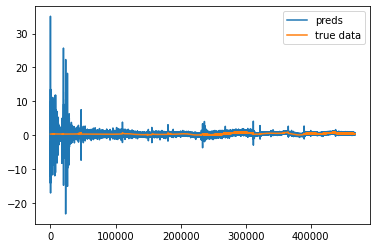

Validation acc: 0.5558
Validation loss: 0.3098


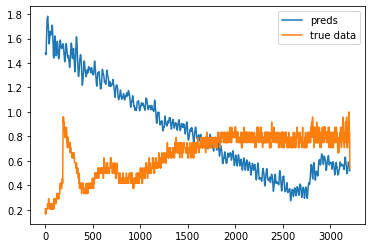


Start of epoch 1
Training loss (for one batch) at step 14611: 0.0097
Training acc over epoch: 0.0592


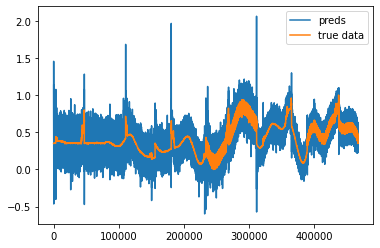

Validation acc: 0.3216
Validation loss: 0.1046


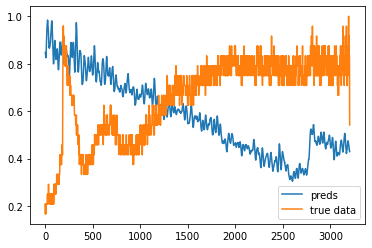


Start of epoch 2
Training loss (for one batch) at step 14611: 0.0040
Training acc over epoch: 0.0531


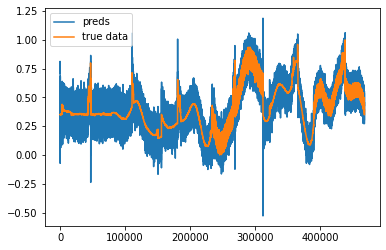

Validation acc: 0.3316
Validation loss: 0.1116


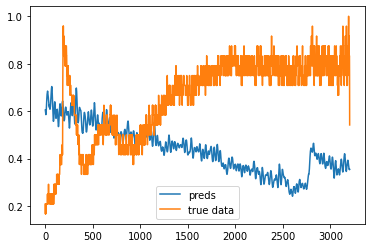


Start of epoch 3
Training loss (for one batch) at step 14611: 0.0026
Training acc over epoch: 0.0631


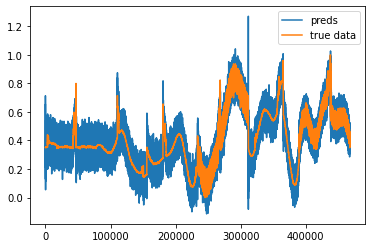

Validation acc: 0.3438
Validation loss: 0.1199


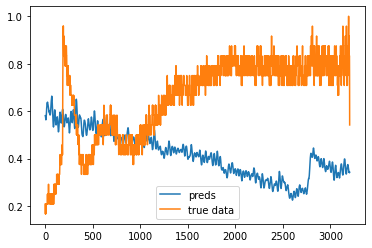


Start of epoch 4
Training loss (for one batch) at step 14611: 0.0020
Training acc over epoch: 0.0549


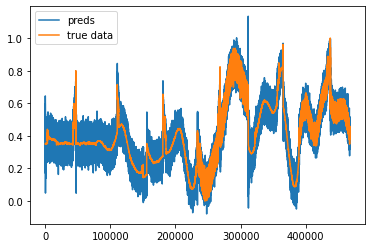

Validation acc: 0.3483
Validation loss: 0.1231


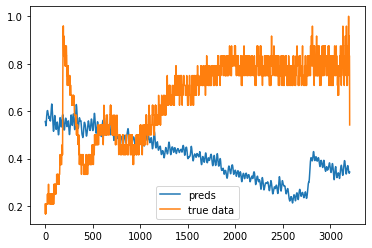


Start of epoch 5
Training loss (for one batch) at step 14611: 0.0017
Training acc over epoch: 0.0358


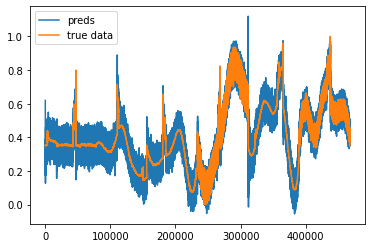

Validation acc: 0.3387
Validation loss: 0.1163


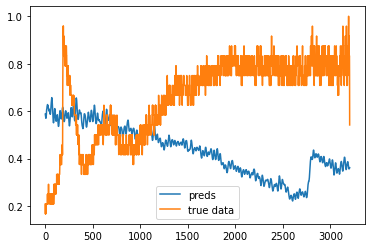


Start of epoch 6
Training loss (for one batch) at step 14611: 0.0015
Training acc over epoch: 0.0345


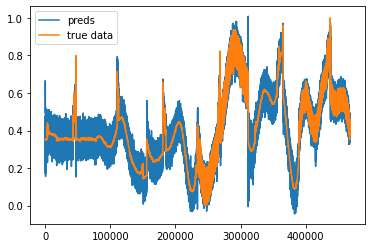

Validation acc: 0.3468
Validation loss: 0.1220


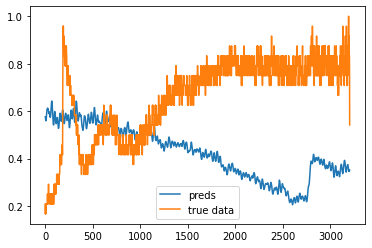


Start of epoch 7
Training loss (for one batch) at step 14611: 0.0015
Training acc over epoch: 0.0401


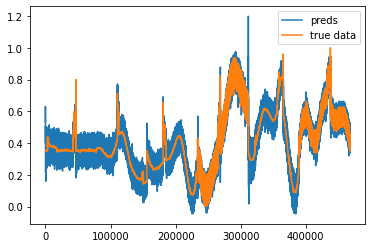

Validation acc: 0.3583
Validation loss: 0.1302


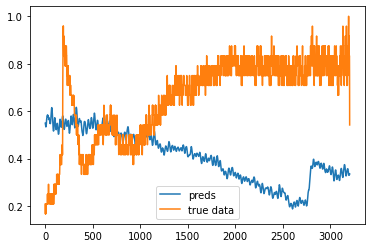


Start of epoch 8
Training loss (for one batch) at step 14611: 0.0014
Training acc over epoch: 0.0333


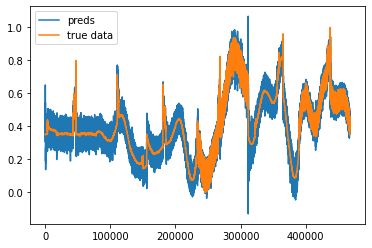

Validation acc: 0.3791
Validation loss: 0.1458


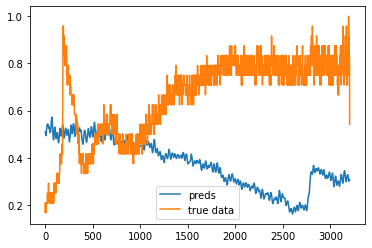


Start of epoch 9
Training loss (for one batch) at step 14611: 0.0014
Training acc over epoch: 0.0371


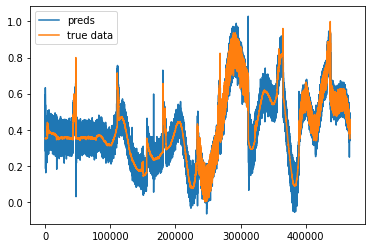

Validation acc: 0.3990
Validation loss: 0.1615


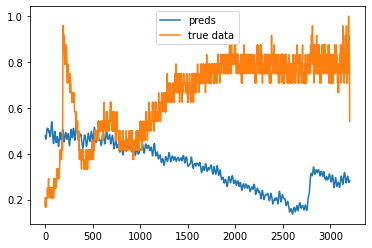


Start of epoch 10
Training loss (for one batch) at step 14611: 0.0014
Training acc over epoch: 0.0314


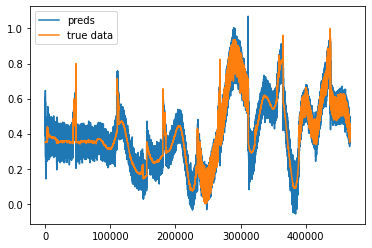

Validation acc: 0.4204
Validation loss: 0.1793


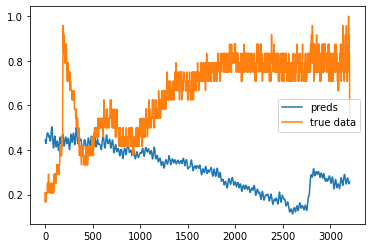


Start of epoch 11
Training loss (for one batch) at step 14611: 0.0015
Training acc over epoch: 0.0299


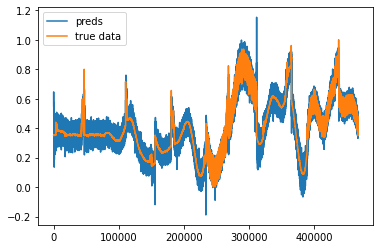

Validation acc: 0.4381
Validation loss: 0.1947


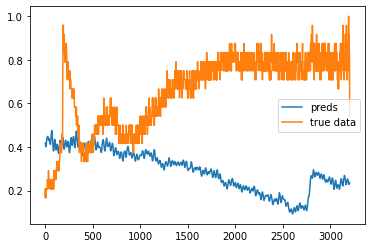


Start of epoch 12


In [ ]:
x_data_train,y_data_train,x_data_valid,y_data_valid = read_excel_files(True)
predictions = evaluate_model(x_data_train,y_data_train,x_data_valid, y_data_valid, n_timesteps=128)

In [ ]:
def grid_search_config():
  '''
  method which initialize the configuration for the grid search algorithm in order to find the best model hyperparams
  '''
  # define scope of configs
  dilation_rate = [2,3,4]
  n_features = [32, 64, 128]
  convs = [ [1,2,4,6,8,16,32] , [1,3,9,27], [1,4,16,64] ]
  n_timesteps = [ 64,54,128 ]
  n_batch = [32, 64]
  # create configs
  configs = list()
  for i,dil in enumerate(dilation_rate):
    for j in n_features:
      for k in n_batch:
        cfg = [dil,convs[i], n_timesteps[i],  j, k]
        configs.append(cfg)
  print('Total configs: %d' % len(configs))
  return configs


def repeat_evaluate(train_x, train_y,valid_x,valid_y, config, n_repeats):
  
  # convert config to a key
  key = str(config)
  print('start model with : ', key)

  #setup model params with grid search configuration params
  n_channels = config[3]
  n_timesteps = config[2]
  convs  = config[1]
  batch_size = config[4]
  n_features = 7

  train_x, train_y = to_supervised(train_x,train_y,n_timesteps)
  valid_x, valid_y = to_supervised(valid_x,valid_y,n_timesteps)
  train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
  val_dataset = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
  model = Wave(n_channels,n_timesteps, n_features, convs)
  train_dataset = train_dataset.batch(batch_size)
  val_dataset = val_dataset.batch(batch_size)
  # fit and evaluate the model n times
  scores = [fit(model, train_dataset, val_dataset) for _ in range(n_repeats)]
  # summarize score
  result = sum(scores)/len(scores)
  print('> Model[%s] %.3f' % (key, result))
  return (key, result)
 
def grid_search(train_x, train_y,valid_x,valid_y, cfg_list, n_repeats=50):
	# evaluate configs
	scores = [repeat_evaluate(train_x, train_y,valid_x,valid_y, cfg, n_repeats) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

x_data_train,y_data_train,x_data_valid,y_data_valid = read_excel_files()
cfg = grid_search_config()

train_x, train_y, scaler = normalize(x_data_train, y_data_train)
valid_x = scaler.fit_transform(x_data_valid)
valid_y = scaler.fit_transform(y_data_valid)
#create sequences


grid_search(train_x, train_y,valid_x,valid_y,cfg)

./Short-FBT-9.xlsx
./Short-FBT-4.xlsx
./Short-FBT-3.xlsx
./Short-FBT-8.xlsx
./Short-FBT-5.xlsx
./Short-FBT-12.xlsx
./Short-FBT-11.xlsx
./Short-FBT-10.xlsx
./Short-FBT-6.xlsx
./Short-FBT-2.xlsx
./Short-FBT-7.xlsx
(36965, 3)
Total configs: 18
start model with :  [2, [1, 2, 4, 6, 8, 16, 32], 64, 32, 32]
> Model[[2, [1, 2, 4, 6, 8, 16, 32], 64, 32, 32]] 0.613
start model with :  [2, [1, 2, 4, 6, 8, 16, 32], 64, 32, 64]
> Model[[2, [1, 2, 4, 6, 8, 16, 32], 64, 32, 64]] 0.858
start model with :  [2, [1, 2, 4, 6, 8, 16, 32], 64, 64, 32]
> Model[[2, [1, 2, 4, 6, 8, 16, 32], 64, 64, 32]] 0.880
start model with :  [2, [1, 2, 4, 6, 8, 16, 32], 64, 64, 64]
> Model[[2, [1, 2, 4, 6, 8, 16, 32], 64, 64, 64]] 0.843
start model with :  [2, [1, 2, 4, 6, 8, 16, 32], 64, 128, 32]
> Model[[2, [1, 2, 4, 6, 8, 16, 32], 64, 128, 32]] 0.840
start model with :  [2, [1, 2, 4, 6, 8, 16, 32], 64, 128, 64]
> Model[[2, [1, 2, 4, 6, 8, 16, 32], 64, 128, 64]] 0.835
start model with :  [3, [1, 3, 9, 27], 54, 32, 32]
> 